## **Paths**

In [ ]:
image_folder = 'NLMCXR_png'
df_path = 'pickle_files/df_final.pkl'
chexnet_weights = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

## **Imports**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='white')

import joblib 
import os

import cv2
import imgaug.augmenters as iaa

from nltk.translate.bleu_score import sentence_bleu 

import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.compat.v1.enable_eager_execution()


## **Loading Data**

In [ ]:
df = pd.read_pickle(df_path)
col = ['image_1', 'image_2', 'impression', 'xml file name']
df = df[col].copy()

#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row))
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 


In [ ]:
df.shape

(4033, 7)

In [ ]:
df.head()

,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,NLMCXR_png\CXR1_1_IM-0001-3001.png,NLMCXR_png\CXR1_1_IM-0001-4001.png,normal chest x .,1.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>
1,NLMCXR_png\CXR10_IM-0002-1001.png,NLMCXR_png\CXR10_IM-0002-2001.png,no acute cardiopulmonary process .,10.xml,<CLS> no acute cardiopulmonary process . <END>,<CLS> no acute cardiopulmonary process .,no acute cardiopulmonary process . <END>
2,NLMCXR_png\CXR100_IM-0002-1001.png,NLMCXR_png\CXR100_IM-0002-2001.png,no active disease .,100.xml,<CLS> no active disease . <END>,<CLS> no active disease .,no active disease . <END>
3,NLMCXR_png\CXR1000_IM-0003-1001.png,NLMCXR_png\CXR1000_IM-0003-2001.png,increased opacity in the right upper lobe with...,1000.xml,<CLS> increased opacity in the right upper lob...,<CLS> increased opacity in the right upper lob...,increased opacity in the right upper lobe with...
4,NLMCXR_png\CXR1000_IM-0003-2001.png,NLMCXR_png\CXR1000_IM-0003-3001.png,increased opacity in the right upper lobe with...,1000.xml,<CLS> increased opacity in the right upper lob...,<CLS> increased opacity in the right upper lob...,increased opacity in the right upper lobe with...


In [ ]:
# Checking the counts of the impressions we have
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                        383
no acute cardiopulmonary findings .                                                                                           172
no acute cardiopulmonary disease .                                                                                            147
no acute cardiopulmonary abnormalities .                                                                                      141
no active disease .                                                                                                           137
                                                                                                                             ... 
no acute cardiopulmonary abnormality . no active disease .                                                                      1
scarring or pleural plaque in the left upper lobe with partial resection of the posterior 

In [ ]:
# Data highly imbalanced, drop duplicated points
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3820 entries, 0 to 4031
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_1           3820 non-null   object
 1   image_2           3820 non-null   object
 2   impression        3820 non-null   object
 3   xml file name     3820 non-null   object
 4   impression_final  3820 non-null   object
 5   impression_ip     3820 non-null   object
 6   impression_op     3820 non-null   object
dtypes: object(7)
memory usage: 238.8+ KB


In [ ]:
impression_counts = df['impression'].value_counts()
df = df.merge(impression_counts, left_on = 'impression', right_index = True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [ ]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final', 'impression_ip', 'impression_op', 'impression_counts']
del df['impression_x']

df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,normal chest x .,NLMCXR_png\CXR1_1_IM-0001-3001.png,NLMCXR_png\CXR1_1_IM-0001-4001.png,1.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>,3
1274,normal chest x .,NLMCXR_png\CXR2145_IM-0766-1001.png,NLMCXR_png\CXR2145_IM-0766-2001.png,2145.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>,3
1732,normal chest x .,NLMCXR_png\CXR2545_IM-1054-1001.png,NLMCXR_png\CXR2545_IM-1054-1002.png,2545.xml,<CLS> normal chest x . <END>,<CLS> normal chest x .,normal chest x . <END>,3
1,no acute cardiopulmonary process .,NLMCXR_png\CXR10_IM-0002-1001.png,NLMCXR_png\CXR10_IM-0002-2001.png,10.xml,<CLS> no acute cardiopulmonary process . <END>,<CLS> no acute cardiopulmonary process .,no acute cardiopulmonary process . <END>,87
63,no acute cardiopulmonary process .,NLMCXR_png\CXR1051_IM-0039-5001.png,NLMCXR_png\CXR1051_IM-0039-6001.png,1051.xml,<CLS> no acute cardiopulmonary process . <END>,<CLS> no acute cardiopulmonary process .,no acute cardiopulmonary process . <END>,87


## **Dividing data to train and test**

In [ ]:
from sklearn.model_selection import train_test_split
majority = df[df['impression_counts'] > 5] #selecting records which have impression counts > 5
minority = df[df['impression_counts'] <= 5] #selecting records which have impression counts <= 5

train, test = train_test_split(majority, stratify = majority['impression'].values, test_size = 0.1, random_state = 420)
test_minority_sample = minority.sample(int(0.2 * minority.shape[0]), random_state = 420) #getting some records from minority for test data
minority = minority.drop(test_minority_sample.index, axis = 0)

test = test.append(test_minority_sample)
test = test.reset_index(drop = True)

train = train.append(minority) 
train = train.reset_index(drop = True)
train.shape[0], test.shape[0]

(3257, 563)

In [ ]:
# Upsampling and Downsampling to balance data
from sklearn.utils import resample
df_majority = train[train['impression_counts'] >= 100] 
df_minority = train[train['impression_counts'] <= 5] 
df_middle = train[(train['impression_counts'] > 5) & (train['impression_counts'] < 100)] 

n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_middle.shape[0]


df_minority_upsampled = resample(df_minority, replace = True, n_samples = 3*n1, random_state = 420)

df_majority_downsampled = resample(df_majority, replace = False, n_samples = n2//15, random_state = 420)

df_middle_downsampled = resample(df_middle, replace = False, n_samples = n3//10, random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled, df_middle_downsampled])

train = train.reset_index(drop = True)

train.shape

(4487, 8)

In [ ]:
train.impression.value_counts()

comparison well expanded and clear lungs . mediastinal contour within normal limits . no acute cardiopulmonary abnormality identified .                      21
change . hypoinflation with no visible active cardiopulmonary disease .                                                                                      20
no evidence of acute cardiopulmonary process . stable appearance of the chest .                                                                              19
normal chest film .                                                                                                                                          18
no acute cardiopulmonary abnormality .                                                                                                                       17
                                                                                                                                                             ..
chest . no acute cardiopulmonary finding

In [ ]:
# Saving the dataframe
folder_name = 'pickle_files'
file_name = 'train.pkl'
train.to_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test.to_pickle(os.path.join(folder_name,file_name))

In [ ]:
# Reading the pickle files to get the train and test dataframes
folder_name = 'pickle_files'
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

## **Tokenizer**

In [ ]:
tokenizer = Tokenizer(filters = '', oov_token = '<unk>')

tokenizer.fit_on_texts(train.impression_final.values)

train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 

vocab_size = len(tokenizer.word_index)

caption_len = np.array([len(i) for i in train_captions])

start_index = tokenizer.word_index['<cls>'] #token value of <cls>
end_index = tokenizer.word_index['<end>'] #token value of <end>


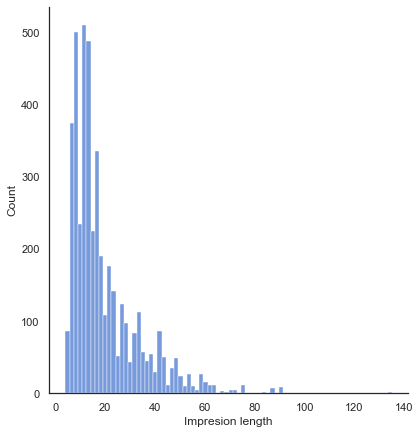


Value Counts for caption length

Length | Counts
8      280
12     272
14     263
7      252
11     238
      ... 
76       2
135      2
78       1
70       1
77       1
Length: 73, dtype: int64

The max and min values of "caption length" is 135 and 4
The 80 percentile values of caption_len which is 28 will be taken as the maximum padded value for each impression


In [ ]:
# Visualizing the impression length
ax = sns.displot(caption_len, height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()

print('\nValue Counts for caption length\n')
print('Length | Counts')
print(pd.Series(caption_len).value_counts())
print('\nThe max and min values of "caption length" is %i and %i' % (max(caption_len), min(caption_len)))
print('The 80 percentile values of caption_len which is %i will be taken as the maximum padded value for each impression' % (np.percentile(caption_len, 80)))
max_pad = int(np.percentile(caption_len, 80))


### **Hyperparameters**

In [ ]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

## **Data pipeline**

In [ ]:
class Dataset():
  # images converted to context vector and corresponding captions
    def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
        """
        df = dataframe containing image_1 and image_2 and the impression.
        """
        self.image1 = df.image_1
        self.image2 = df.image_2
        self.caption = df.impression_ip #input
        self.caption1 = df.impression_op  # output
        self.input_size = input_size 
        self.tokenizer = tokenizer
        self.augmentation = augmentation
        self.max_pad = max_pad

        #image augmentation
        
        self.aug1 = iaa.Fliplr(1) #flip images horizaontally
        self.aug2 = iaa.Flipud(1) #flip images vertically


    def __getitem__(self,i):
        """
        Gets the record at index 'i', resizes the images and applies augmentation
        """
        image1 = cv2.imread(self.image1[i], cv2.IMREAD_UNCHANGED)/255 
        image2 = cv2.imread(self.image2[i], cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
        image1 = cv2.resize(image1, self.input_size, interpolation = cv2.INTER_NEAREST)
        image2 = cv2.resize(image2, self.input_size, interpolation = cv2.INTER_NEAREST)
        
        # Print messages if missing images are found
        if image1.any()==None:
            print("%i , %s image sent null value"%(i,self.image1[i]))
        if image2.any()==None:
            print("%i , %s image sent null value"%(i,self.image2[i]))


        # Tokenizing and Padding the captions
        caption = self.tokenizer.texts_to_sequences(self.caption[i : i + 1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption = pad_sequences(caption, maxlen = self.max_pad, padding = 'post') #opshape:(input_length,)
        caption = tf.squeeze(caption, axis=0) #opshape = (input_length,) removing unwanted axis if present

        caption1 = self.tokenizer.texts_to_sequences(self.caption1[i : i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

        caption1 = pad_sequences(caption1, maxlen = self.max_pad, padding = 'post') #opshape: (input_length,)
        caption1 = tf.squeeze(caption1, axis = 0) #opshape = (input_length,) removing unwanted axis if present



        # Applying the augmentation
        if self.augmentation:  
            a = np.random.uniform()
            
            if a<0.333:
                image1 = self.aug1.augment_image(image1)
                image2 = self.aug1.augment_image(image2)
                
            elif a<0.667:
                image1 = self.aug2.augment_image(image1)
                image2 = self.aug2.augment_image(image2)
                
            else: 
                #applying no augmentation
                pass;

    
        return image1,image2,caption,caption1

    
    def __len__(self):
        return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):    
    """
    Divide data into batches.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] 
        data = [self.dataset[j] for j in indexes] 
        
        batch = [np.stack(samples, axis = 0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad
        return tuple([[batch[0], batch[1], batch[2]], batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): 
        # returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): 
        # runs at the end of each epoch to shuffle data
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

## **Encoder**
[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Dense-121 layered model which is trained on thousands of chest x-ray images for the classification of 14 diseases. We can load the weights of that model and pass the image through it.

In [ ]:
def create_chexnet(chexnet_weights = chexnet_weights):
    """
    chexnet_weights: weights value in .h5 format of chexnet
    creates a chexnet model with preloaded weights present in chexnet_weights file
    """
    model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer

    #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
    x = model.output #output from chexnet
    x = GlobalAveragePooling2D()(x)
    x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

    chexnet = tf.keras.Model(inputs = model.input,outputs = x)
    chexnet.load_weights(chexnet_weights)
    chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
    return chexnet

In [ ]:
chexnet = create_chexnet()
chexnet.trainable = False

In [ ]:
del chexnet

## Baseline Encoder Decoder Model

### Image Encoder Layer

In [ ]:
class Image_encoder(tf.keras.layers.Layer):
    """
    Return image backbone features after passing it through chexnet.
    """
    def __init__(self, name = "image_encoder_block"):
        super().__init__()
        self.chexnet = create_chexnet()
        self.chexnet.trainable = False
        
    def call(self,data):
        op = self.chexnet(data)
        return op

## **Model**

In [ ]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [ ]:
# Using Glove to get initial weights for embedding layer in model
glove = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f: #taking 300 dimesions
    for line in f:
        word = line.split() # stored as string: "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
        glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None: #if the word is found in glove vectors
        embedding_matrix[i] = embedding_vector[:embedding_dim]

In [ ]:
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) 
image2 = Input(shape = (input_size + (3,))) 
caption = Input(shape = (max_pad,))

# Extract Images backbone features to be used as decoder context vector
img_encoder = Image_encoder() 
bk_feat1 = img_encoder(image1)
bk_feat2 = img_encoder(image2)
bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) 

image_dense = Dense(dense_dim, activation = 'relu', name = 'Image_dense', use_bias = 'False')

                    
image_bkbone = image_dense(bk_features_concat) 
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1)


embedding = Embedding(input_dim  = vocab_size+1, output_dim = embedding_dim, input_length = max_pad,
                      mask_zero = True, weights = [embedding_matrix], name = 'embedding')
embed_op = embedding(caption)

lstm_layer = LSTM(units = lstm_units, return_sequences= True, return_state = True)
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim)

op_dense = Dense(vocab_size+1, activation = 'softmax', name = 'output_dense') #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_encoder (Image_encoder)  (None, 1024)         7037504     ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

## **Customized Loss Function**

In [ ]:
#Loss function
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

def custom_loss(y_true, y_pred):
    
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    loss = loss_func(y_true, y_pred)
    
    mask = tf.cast(mask, dtype = loss.dtype)
    
    loss = loss * mask
    
    return tf.reduce_mean(loss)

## **Training**

In [ ]:
lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer = optimizer, loss = custom_loss, metrics = ['accuracy'])

In [ ]:
tf.keras.backend.clear_session()
tb_filename = 'Simple_Encoder_Decoder/'
tb_file = os.path.join('Medical image Reporting', tb_filename)
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('Medical image Reporting', model_filename)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, verbose = 2),
    
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save, save_best_only = True, save_weights_only = True, verbose = 2),
    tf.keras.callbacks.TensorBoard(histogram_freq=1, log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=10**-7, verbose = 2)
                                   
] 

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )

Epoch 1/10
 7/44 [===>..........................] - ETA: 1:39 - loss: 1.7145 - accuracy: 0.0329  

In [ ]:
model_filename = 'Simple_Encoder_Decoder_Base.h5'
model_save = os.path.join('Medical image Reporting',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

## **Training vs Validation**

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir 'Medical image Reporting/'

## **Predictions**

In [ ]:
def get_bleu(reference,prediction):
    """
    Returns 1-gram,2-gram,3-gram and 4-gram bleu scores.
    """
    
    reference = [reference.split()]
    prediction = prediction.split()
    
    bleu1 = sentence_bleu(reference, prediction, weights = (1,0,0,0),)
    bleu2 = sentence_bleu(reference, prediction, weights = (0.5,0.5,0,0))
    bleu3 = sentence_bleu(reference, prediction, weights = (0.33,0.33,0.33,0))
    bleu4 = sentence_bleu(reference, prediction, weights = (0.25,0.25,0.25,0.25))

    return bleu1,bleu2,bleu3,bleu4

In [ ]:
#Calculate bleu scores for every record
def mean_bleu(test, predict, model = model1, **kwargs):
    """
    Takes in a Dataframe and a predict function then outputs the mean BLEU scores for 1, 2, 3 and 4-grams
    """
    if kwargs != None:
        top_k = kwargs.get('top_k')
    else:
        top_k = None
        bleu1, bleu2, bleu3, bleu4 = [],[],[],[]
    
    for index, data in test.iterrows():
        if top_k == None:
            predict_val = predict(data['image_1'], data['image_2'], model = model) 
        else:
            predict_val = predict(data['image_1'], data['image_2'], model = model, top_k = top_k)
        
        true = data.impression
        bleu_score = get_bleu(true,predict_val)
        bleu1.append(bleu_score[0])
        bleu2.append(bleu_score[1])
        bleu3.append(bleu_score[2])
        bleu4.append(bleu_score[3])
        
    return np.array(bleu1).mean(), np.array(bleu2).mean(), np.array(bleu3).mean(), np.array(bleu4).mean()

### **Greedy Search**

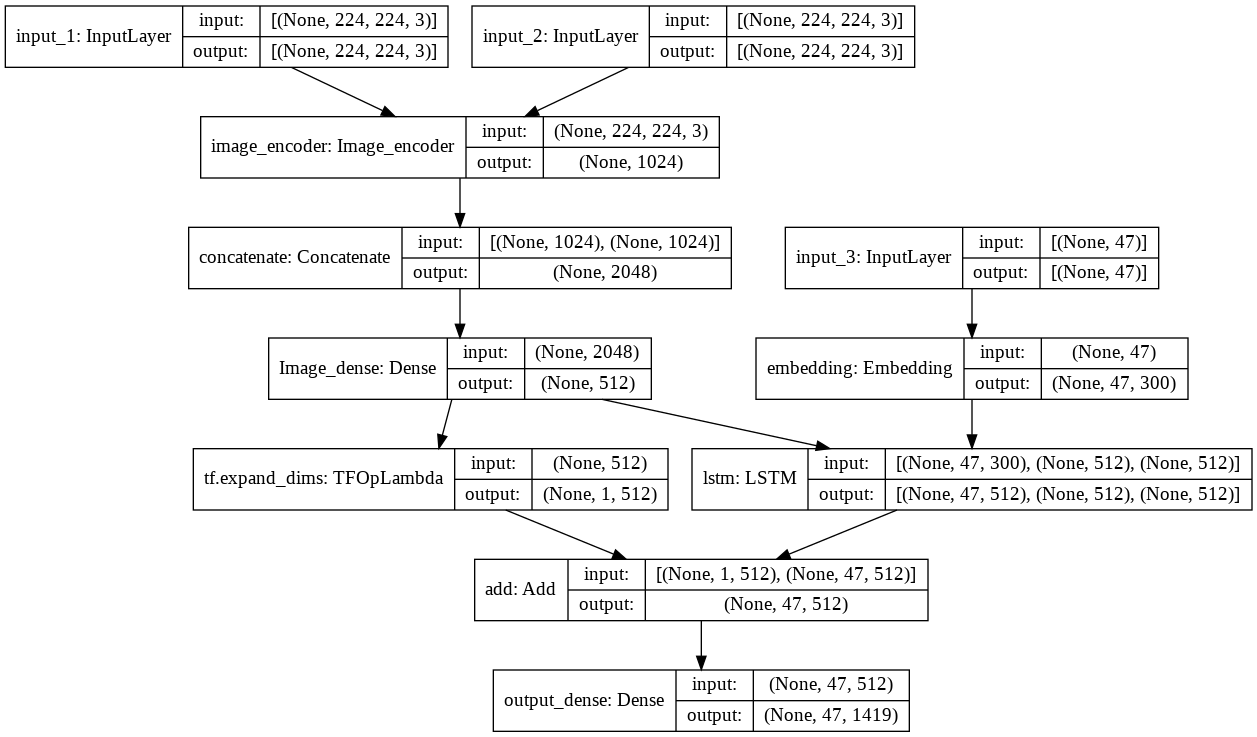

In [ ]:
def greedy_search_predict(image1, image2, model = model1):
    """
    Takes in two X-Ray images then produces a caption uses the greedy search algorithm
    """
    image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
    image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
    image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)


    image1 = model.get_layer('image_encoder')(image1) #output from chexnet
    image2 = model.get_layer('image_encoder')(image2)


    concat = model.get_layer('concatenate')([image1,image2])
    image_dense = model.get_layer('Image_dense')(concat)
    bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)


    states = [image_dense, image_dense]
    a = []
    pred = []
    for i in range(max_pad):
        if i==0: 
            #if first word
            caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
        
        caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
        caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
        states = [state_h,state_c]

        add = model.get_layer('add')([bk_feat,caption]) #add
        output = model.get_layer('output_dense')(add) #1*1*vocab_size (batch_size=1)

        #prediction
        max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
        caption = np.array(max_prob) #will be sent to embedding for next iteration
        if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
            break;
        else:
            a.append(tf.squeeze(max_prob).numpy())
            
    return tokenizer.sequences_to_texts([a])[0]

In [ ]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(greedy_search_predict(image1, image2, model = model))

In [ ]:
%%time
_ = mean_bleu(test,greedy_search_predict)

In [ ]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])

In [ ]:
result

### **Beam Search**

In [ ]:
def encoder_op(image1, image2, model = model1):
    """
    Given image1 and image2 filepath, outputs their backbone features which will be input to the decoder
    """
    image1 = cv2.imread(image1, cv2.IMREAD_UNCHANGED) / 255 
    image2 = cv2.imread(image2, cv2.IMREAD_UNCHANGED) / 255

    image1 = tf.expand_dims(cv2.resize(image1, input_size, interpolation = cv2.INTER_NEAREST), axis = 0) #introduce batch and resize
    image2 = tf.expand_dims(cv2.resize(image2, input_size, interpolation = cv2.INTER_NEAREST), axis = 0)

    image1 = model.get_layer('image_encoder')(image1) #output from chexnet
    image2 = model.get_layer('image_encoder')(image2)

    concat = model.get_layer('concatenate')([image1, image2])
    image_dense = model.get_layer('Image_dense')(concat)
    bk_feat = tf.keras.backend.expand_dims(image_dense, axis = 1)
    states = [image_dense, image_dense]
    
    return bk_feat,states

In [ ]:
def beam_search_predict(image1, image2, top_k = 3, max_pad = max_pad, model = model1):
    """
    Given image1, image2 get the top beam search predicted sentence
    """
    k = top_k
    cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
    bk_feat, states = encoder_op(image1, image2)
    seq_score = [[cls_token, 0, states]] #[[[3], 0]]
    finished_seq_score = []
    
    for i in range(max_pad): #traverse through all lengths
        all_candidates = [] #stores all the top k sequences along with their scores
        new_seq_score = [] #stores the seq_score which does not have the <end> token
    
        for s in seq_score: #traverse for all top k sequences
            
            text_input = s[0][-1] #getting the last predicted output
            states = s[2]
            caption = model.get_layer('embedding')(np.array([[text_input]])) #ip must be in shape (batch_size,seq length,dim)
            caption,state_h,state_c = model.get_layer('lstm')(caption, initial_state = states)
            states = [state_h, state_c]
            add = model.get_layer('add')([bk_feat, caption])
            output = model.get_layer('output_dense')(add)[0][0] #(vocab_size,)
            top_words = tf.argsort(output,direction = 'DESCENDING')[:k] #get the top k words

            seq, score, _ = s

            for t in top_words.numpy():
                #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
                #here since its -(log), lower the score higher the prob
                candidates = [seq + [t], score-np.log(output[t].numpy()), states] #updating the score and seq
                all_candidates.append(candidates)

            seq_score = sorted(all_candidates, key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
            #checks for the <end> token in each sequence obtained
            count = 0
            end_token = tokenizer.word_index['<end>']
            for seq,score,state in seq_score:
                if seq[-1] == end_token: #if the last word of the sequence is <end>
                    finished_seq_score.append([seq, score])
                    count += 1
                else:
                    new_seq_score.append([seq, score, state])
            k -= count #Substracting the no. of finished sentences from beam length
            seq_score = new_seq_score

            if seq_score==[]: #if null array
                break;
            else:
                continue;

    seq_score = finished_seq_score[-1]
    sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
    score = seq_score[1]
      
    return tokenizer.sequences_to_texts([sentence])[0]

In [ ]:
# beam search with top_k = 3.
%%time
k = -1
image1, image2 = test['image_1'].iloc[k], test['image_2'].iloc[k]
print(beam_search_predict(image1, image2, top_k = 3))

In [ ]:
# beam search with top_k = 5.
%%time
k = -1
image1,image2 = test['image_1'].iloc[k], test['image_2'].iloc[k]
print(beam_search_predict(image1, image2, top_k = 5))

In [ ]:
# top_k = 5 is slow so we use 3.
%%time
_ = mean_bleu(test,beam_search_predict)

In [ ]:
k = list(_)
index = 'beam search (top_k = 3)'
temp = pd.DataFrame([k],columns = ["bleu1", "bleu2", "bleu3", "bleu4"], index = [index])
result = result.append(temp)
result

Since greedy search and beam search produce similar results, we'll use the greedy search algorithm since it's faster.

# **Inference**

Now we will predict the captions for all records and see the results manually while also computing BLEU-1 score. We shall use greedy search algorithm with the other models since it is faster.

In [ ]:
%%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['bleu_1_bm'] = np.zeros(test.shape[0]) #beam search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_bm'] = np.zeros(test.shape[0]) #beam search

for index,rows in test.iterrows():
    #greedy search
    predicted_text = greedy_search_predict(rows.image_1, rows.image_2, model1)
    test.loc[index,'prediction_gs'] = predicted_text
    reference = [rows['impression'].split()]
    test.loc[index,'bleu_1_gs'] = sentence_bleu(reference, predicted_text.split(), weights = (1,0,0,0))

    #beam search
    predicted_text = beam_search_predict(rows.image_1, rows.image_2, top_k = 3, model = model1)
    test.loc[index,'prediction_bm'] = predicted_text
    test.loc[index,'bleu_1_bm'] = sentence_bleu(reference, predicted_text.split(), weights = (1,0,0,0))

In [ ]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search

In [ ]:
test['prediction_bm'].value_counts()*100/test.shape[0] #beam search

From the above results, we can see that for every datapoint the model is predicting "no acute cardiopulmonary abnormality" suggesting the model has overfitted.

## Random predictions on test data

In [ ]:
def final_caption_pred(image1, image2, method = "beam", top_k = 3, model = model1):
    """
    Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
    method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
    """
    if method == 'greedy':
        pred_caption = greedy_search_predict(image1, image2, model)
    elif method == 'beam':
        pred_caption = beam_search_predict(image1, image2, top_k = top_k, model = model)
    else:
        print("Enter 'beam' for beam search or 'greedy' for greedy search")
  
    return pred_caption

In [ ]:
def inference(image1, image2, true_caption, model = model1, top_k = [3], image_size = (10,20)):
    """
    Given 2 images, the true caption, the model and the range of top_k
    prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
    """
    image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
    image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
    if type(top_k)==int:
        top_k = [top_k] #changing it to list if top_k given is of int type
    greedy_caption = final_caption_pred(image1,image2,method='greedy',model=model) #getting the greedy search prediction

      #printing the 2 images
    plt.figure(figsize = image_size)
    plt.subplot(121)
    plt.imshow(image1_array)
    plt.axis("off")

    plt.subplot(122)
    plt.imshow(image2_array)
    plt.axis("off")
    plt.show()

    print("\nTrue caption: '%s'"%(true_caption))
    print("Predicted caption(greedy search): '%s'"%(greedy_caption))
    # beam search of top_k
    if top_k != None:
        for i in top_k:
            beam_caption = final_caption_pred(image1,image2,method='beam',model=model,top_k = i)
            print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))


### Correct Captions

In [ ]:
i = test[test['bleu_1_gs'] > 0.8].sample(5).index
for k in i:
    image1,image2 = test['image_1'][k], test['image_2'][k]
    true_caption = test['impression'][k]
    inference(image1,image2,true_caption)

### Incorrect Caption

In [ ]:
i = test[test['bleu_1_gs'] < 0.3].sample(5).index
for k in i:
    image1,image2 = test['image_1'][k], test['image_2'][k]
    true_caption = test['impression'][k]
    inference(image1,image2,true_caption)

# For comparisons

## Train

In [ ]:
k = 100
image1, image2 = train['image_1'][k], train['image_2'][k]
true_caption = train['impression'][k]
inference(image1, image2, true_caption, top_k = None)

In [ ]:
k = 1000
image1,image2 = train['image_1'][k], train['image_2'][k]
true_caption = train['impression'][k]
inference(image1, image2, true_caption, top_k = None)

In [ ]:
k = 4000
image1,image2 = train['image_1'][k], train['image_2'][k]
true_caption = train['impression'][k]
inference(image1, image2, true_caption, top_k = None)

## Test

In [ ]:
k = 160
image1, image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption, top_k = None)

In [ ]:
k = 290
image1,image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption, top_k = None)

In [ ]:
test['image_1'][290], test['image_2'][290]

In [ ]:
k = 25
image1, image2 = test['image_1'][k], test['image_2'][k]
true_caption = test['impression'][k]
inference(image1, image2, true_caption, top_k = None)

# Conclusion

In [ ]:
result